# Анализ поведения слушателей Spotify

**Цель проекта:** Выявить ключевые паттерны поведения слушателей на основе истории прослушиваний, сфокусировавшись на лояльности к контенту, структуре сессий и эффективности автоплея.

**Описание данных:**

* `spotify_track_uri` – уникальный идентификатор (URI), присваиваемый каждому треку Spotify
* `ts` – временная метка начала воспроизведения трека
* `platform` – платформа или устройство, используемое для воспроизведения (например, веб-плеер)
* `ms_played` – количество миллисекунд воспроизведения трека до остановки или пропуска
* `track_name` – Название/название трека
* `artist_name` – исполнитель или группа, исполнившая трек
* `album_name` – Альбом, к которому принадлежит трек
* `reason_start` – указывает, что вызвало воспроизведение (например, автовоспроизведение, щелчок пользователя)
* `reason_end` – Описывает, как завершилось воспроизведение (например, трек завершен, пропущен)
* `shuffle` – логическое поле, указывающее, был ли включен режим перемешивания во время воспроизведения
* `skipped` – логическое поле, указывающее, был ли трек пропущен (True) или воспроизведен полностью (False)

**Задачи:**

1. **Анализ лояльности к трекам**  
   *Исследование факторов завершения прослушивания*  
   - **Метрики:**  
     • Процент пропущенных треков (`skipped`)  
     • Распределение времени прослушивания (`ms_played`)  
     • Соотношение полного/частичного прослушивания  
   - **Анализ:**  
     • Сравнение по платформам (`platform`) и режимам (`shuffle`)  
     • Выявление треков с аномальными показателями пропуска  
     • Корреляция причин начала (`reason_start`) и завершения (`reason_end`)  
   - **Визуализация:**  
     • Топ-10 лояльных/пропускаемых треков  
     • Распределение времени прослушивания по устройствам  

2. **Анализ сессий прослушивания**  
   *Выявление паттернов пользовательских сеансов*  
   - **Метод сегментации:**  
     • Определение границ сессий по интервалам между `ts` (порог 30+ мин)  
     • Кластеризация по времени суток/дням недели  
   - **Ключевые метрики:**  
     • Длительность сессии (разница первого/последнего `ts`)  
     • Количество треков в сессии  
     • Плотность прослушивания (сумма `ms_played` / длительность)  
   - **Исследование:**  
     • Динамика `skipped` внутри сессии  
     • Частота завершения (`reason_end`) по позиции трека  
     • Распределение сессий по типам платформ  

3. **Оценка эффективности автоплея**  
   *Анализ влияния автоматических рекомендаций*  
   - **Фокусные метрики:**  
     • Процент пропусков в автоплее (`reason_start = 'autoplay'`)  
     • Частота завершения сессии после автоплея  
   - **Сравнительный анализ:**  
     • Пропуски в автоплее vs ручном запуске (`clickrow`)  
     • Распределение причин завершения (`reason_end`)  
   - **Выявление аномалий:**  
     • Треки-индикаторы конца сессии (корреляция с `endplay`)  
     • Платформы с наибольшим количеством прерываний  

**Адаптация под доступные данные:**
- Использование абсолютного времени прослушивания (`ms_played`)
- Анализ временных меток (`ts`) без внешних источников
- Группировка по артистам (`artist_name`) и альбомам (`album_name`)
- Кросс-анализ поведенческих флагов (`skipped`, `shuffle`)

**Синергия задач:**
1. Результаты сегментации → Контекст для анализа автоплея
2. Выявленные "антихиты" → Корреляция с прерыванием сессий
3. Паттерны завершения сессий → Интерпретация метрик лояльности

**Ожидаемый результат:**  
Система взаимосвязанных инсайтов о поведении пользователей, выявленная на основе метаданных треков, временных меток и флагов взаимодействия.

In [1]:
# импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Загрузка данных
file_path = "spotify_history.csv"
df = pd.read_csv(file_path)

# Просмотр первых строк и структуры данных
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149860 entries, 0 to 149859
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   spotify_track_uri  149860 non-null  object
 1   ts                 149860 non-null  object
 2   platform           149860 non-null  object
 3   ms_played          149860 non-null  int64 
 4   track_name         149860 non-null  object
 5   artist_name        149860 non-null  object
 6   album_name         149860 non-null  object
 7   reason_start       149717 non-null  object
 8   reason_end         149743 non-null  object
 9   shuffle            149860 non-null  bool  
 10  skipped            149860 non-null  bool  
dtypes: bool(2), int64(1), object(8)
memory usage: 10.6+ MB


In [4]:
df.head()

,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped
0,2J3n32GeLmMjwuAzyhcSNe,2013-07-08 02:44:34,web player,3185,"Say It, Just Say It",The Mowgli's,Waiting For The Dawn,autoplay,clickrow,False,False
1,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False
2,487OPlneJNni3NWC8SYqhW,2013-07-08 02:50:24,web player,285386,Born To Die,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False
3,5IyblF777jLZj1vGHG2UD3,2013-07-08 02:52:40,web player,134022,Off To The Races,Lana Del Rey,Born To Die - The Paradise Edition,trackdone,clickrow,False,False
4,0GgAAB0ZMllFhbNc3mAodO,2013-07-08 03:17:52,web player,0,Half Mast,Empire Of The Sun,Walking On A Dream,clickrow,nextbtn,False,False


### Анализ лояльности к трекам:

In [6]:
# Преобразуем временную метку к datetime
df['ts'] = pd.to_datetime(df['ts'])

# Процент пропущенных треков
skipped_percent = df['skipped'].mean() * 100

skipped_percent

5.250900840784732

In [ ]:
# Распределение времени прослушивания
ms_played_stats = df['ms_played'].describe()

ms_played_stats

count    1.498600e+05
mean     1.283166e+05
std      1.178401e+05
min      0.000000e+00
25%      2.795000e+03
50%      1.388400e+05
75%      2.185070e+05
max      1.561125e+06
Name: ms_played, dtype: float64

In [ ]:
# Соотношение полного и частичного прослушивания
# Предположим, что "полное" прослушивание — это >90 секунд (90000 мс)
full_threshold = 90000
df['fully_played'] = df['ms_played'] >= full_threshold
full_vs_partial = df['fully_played'].value_counts(normalize=True) * 100

full_vs_partial

fully_played
True     56.766983
False    43.233017
Name: proportion, dtype: float64

In [ ]:
# Сравнение по платформам
platform_skipped = df.groupby('platform')['skipped'].mean().sort_values(ascending=False) * 100

platform_skipped

platform
windows           14.074512
iOS               10.265661
mac                6.122449
android            5.182340
cast to device     0.000000
web player         0.000000
Name: skipped, dtype: float64

In [10]:
# Сравнение по режимам shuffle
shuffle_skipped = df.groupby('shuffle')['skipped'].mean().sort_values(ascending=False) * 100

shuffle_skipped

shuffle
True     5.568949
False    4.323745
Name: skipped, dtype: float64

**Промежуточные выводы**

Общие метрики:

* Процент пропущенных треков: 5.25%
* Среднее время прослушивания: ~128,316 мс (≈ 2.1 мин)

Распределение времени (ms_played):

* Медиана: 138,840 мс
* 25-й перцентиль: 2,795 мс (много коротких прослушиваний)
* Макс: ~26 мин

Полнота прослушивания:

* Полностью воспроизведено (>90 сек): 56.77%
* Частично воспроизведено: 43.23%

По платформам (Процент пропусков):

* Windows: 14.07%
* iOS: 10.27%
* Mac: 6.12%
* Android: 5.18%
* Web Player: 0%
* Cast to Device: 0%

Обратим внимание: Web Player и Cast to Device показывают 0% пропусков — возможно, данные неполные или флаг `skipped` не срабатывает корректно для них.

Пропуски в зависимости активации режима `Shuffle`:
* Включен 5.57%
* Выключен 4.32%

Слегка выше процент пропусков при включённом `Shuffle`.

In [12]:
# Треки с наибольшим процентом пропусков (при условии, что у трека не менее 20 прослушиваний)
track_skip_stats = (
    df.groupby(['track_name', 'artist_name'])
    .agg(plays=('skipped', 'count'), skips=('skipped', 'sum'))
    .assign(skip_rate=lambda x: x['skips'] / x['plays'])
    .query("plays >= 20")
    .sort_values(by='skip_rate', ascending=False)
)

track_skip_stats

,,plays,skips,skip_rate
track_name,artist_name,,,
Drag Me Down,One Direction,20,18,0.900000
Paraíso,Dvicio,33,29,0.878788
Check Yes Juliet,We The Kings,20,13,0.650000
Isn't She Lovely,Stevie Wonder,24,11,0.458333
Photograph,Ed Sheeran,54,21,0.388889
...,...,...,...,...
Mamunia - 2010 Remaster,Paul McCartney,85,0,0.000000
Malibu Nights,LANY,22,0,0.000000
Magic Place,The Mud Howlers,36,0,0.000000


In [14]:
# Топ-10 самых "пропускаемых" треков
top_skipped_tracks = track_skip_stats.head(10)

top_skipped_tracks

,,plays,skips,skip_rate
track_name,artist_name,,,
Drag Me Down,One Direction,20,18,0.900000
Paraíso,Dvicio,33,29,0.878788
Check Yes Juliet,We The Kings,20,13,0.650000
Isn't She Lovely,Stevie Wonder,24,11,0.458333
Photograph,Ed Sheeran,54,21,0.388889
Superheroes,The Script,55,21,0.381818
Old Thing Back (feat. Ja Rule and Ralph Tresvant),Matoma,51,19,0.372549
Switzerland,The Last Bison,46,17,0.369565
What Do You Mean?,Justin Bieber,61,20,0.327869


In [15]:
# Топ-10 самых "лояльных" треков (с наименьшей долей пропусков)
most_loyal_tracks = track_skip_stats.sort_values(by='skip_rate').head(10)

most_loyal_tracks

,,plays,skips,skip_rate
track_name,artist_name,,,
Love - Remastered 2010,John Lennon,24,0,0.0
I Stand Corrected,Vampire Weekend,34,0,0.0
"I Still Miss Someone - Live at Folsom State Prison, Folsom, CA (1st Show) - January 1968",Johnny Cash,57,0,0.0
I Walk the Line,Johnny Cash,45,0,0.0
I Want To Break Free - Remastered 2011,Queen,58,0,0.0
I Want You (She's So Heavy) - Remastered 2009,The Beatles,42,0,0.0
I Want You Back,The Jackson 5,51,0,0.0
I Ruined You,Keuning,42,0,0.0
I Will Be Found (Lost At Sea),John Mayer,61,0,0.0


In [16]:
# Корреляция между reason_start и reason_end
reason_corr = (
    df.groupby(['reason_start', 'reason_end'])
    .size()
    .unstack(fill_value=0)
)

reason_corr

reason_end,appload,backbtn,clickrow,endplay,fwdbtn,logout,nextbtn,popup,reload,remote,trackdone,trackerror,unexpected-exit,unexpected-exit-while-paused,unknown
reason_start,,,,,,,,,,,,,,,
appload,5,41,0,768,598,164,0,2,0,7,2055,0,5,67,17
autoplay,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
backbtn,0,451,1,129,728,75,0,0,0,3,771,0,1,38,7
clickrow,0,20,19,5217,680,298,6,0,0,62,4605,0,20,261,36
endplay,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
fwdbtn,1,1418,0,1028,42818,687,0,0,0,34,7414,0,29,317,39
nextbtn,0,1,4,0,0,0,13,0,1,0,0,0,0,0,2
playbtn,0,1,0,538,338,29,0,0,0,10,522,0,3,13,4
popup,0,0,0,2,0,0,0,3,0,0,0,0,0,0,0


Корреляция `reason_start` → `reason_end`:
* Автовоспроизведение (`autoplay`) почти не переходит в другие завершения: единичные случаи.

`clickrow` (ручной выбор):
* Чаще всего заканчивается `endplay` (5217 раз)
* Nакже бывает прерывание `fwdbtn` (680), `logout` (298)

`fwdbtn` (пролистывание):
* Ведет к `trackdone` (7414), но часто завершается ещё одним пролистыванием (42,818 раз)

**Выводы:**
* Есть явные "анти-хиты" с >70% пропусков (например, One Direction);
* Автовоспроизведение — почти не используется или отключено;
* Пользователи чаще завершают треки, запущенные вручную;
* Есть устойчивые треки без единого пропуска — кандидаты на «ядерную аудиторию».

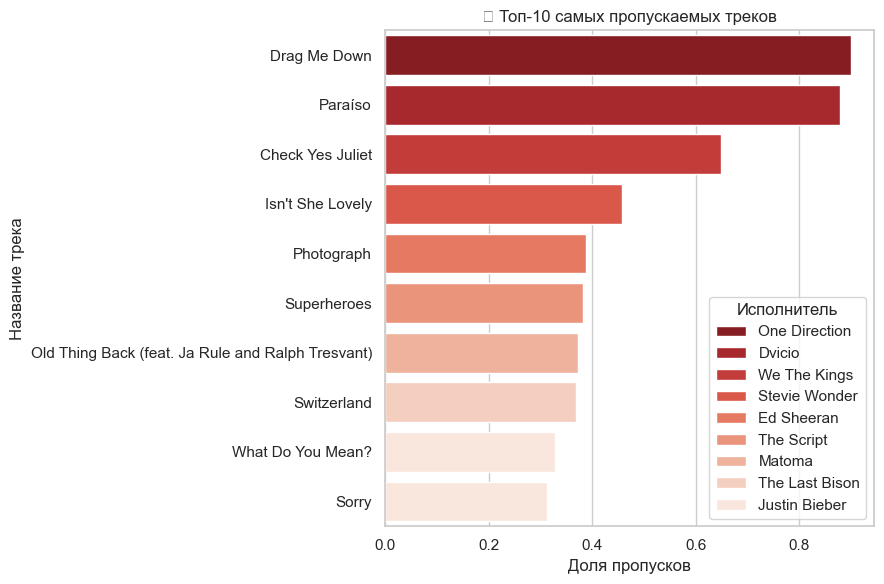

In [26]:
sns.set(style="whitegrid")

# Топ 10 пропускаемых треков
plt.figure(figsize=(9, 6))
sns.barplot(
    data=top_skipped_tracks.reset_index(),
    x='skip_rate',
    y='track_name',
    hue='artist_name',
    dodge=False,
    palette='Reds_r'
)
plt.title('🔥 Топ-10 самых пропускаемых треков')
plt.xlabel('Доля пропусков')
plt.ylabel('Название трека')
plt.legend(title='Исполнитель', loc='lower right')
plt.tight_layout()
plt.show()

## Анализ сессий прослушивания

In [27]:
# Сортируем по времени для сегментации
df_sorted = df.sort_values('ts').copy()

# Разница во времени между треками (в минутах)
df_sorted['ts_diff_min'] = df_sorted['ts'].diff().dt.total_seconds() / 60

# Начало новой сессии — если разрыв > 30 минут
session_threshold = 30
df_sorted['new_session'] = df_sorted['ts_diff_min'] > session_threshold
df_sorted['session_id'] = df_sorted['new_session'].cumsum()

In [28]:
# Вычисляем статистики по сессиям
session_stats = df_sorted.groupby('session_id').agg(
    session_start=('ts', 'min'),
    session_end=('ts', 'max'),
    session_duration_min=('ts', lambda x: (x.max() - x.min()).total_seconds() / 60),
    track_count=('spotify_track_uri', 'count'),
    total_played_ms=('ms_played', 'sum'),
    skipped_ratio=('skipped', 'mean'),
    platform_mode=('platform', lambda x: x.mode()[0] if not x.mode().empty else None),
)

# Удалим сессии с нулевой длительностью (мгновенные)
session_stats = session_stats[session_stats['session_duration_min'] > 0]

# Плотность прослушивания: сколько реально слушали из возможного времени
session_stats['listening_density'] = (
    session_stats['total_played_ms'] / (session_stats['session_duration_min'] * 60 * 1000)
)

session_stats.head()

,session_start,session_end,session_duration_min,track_count,total_played_ms,skipped_ratio,platform_mode,listening_density
session_id,,,,,,,,
0,2013-07-08 02:44:34,2013-07-08 05:47:24,182.833333,65,6611670,0.000000,web player,0.602705
1,2013-07-09 00:42:07,2013-07-09 01:37:03,54.933333,29,3127780,0.000000,web player,0.948962
4,2013-07-10 08:28:05,2013-07-10 08:49:19,21.233333,4,448477,0.750000,windows,0.352023
8,2013-07-13 03:47:11,2013-07-13 04:24:50,37.650000,7,1905329,0.142857,windows,0.843439
9,2013-07-13 20:57:19,2013-07-13 21:14:31,17.200000,5,811501,1.000000,windows,0.786338


In [29]:
# Добавим к session_stats столбцы с днем недели и временем суток
session_stats['start_hour'] = session_stats['session_start'].dt.hour
session_stats['weekday'] = session_stats['session_start'].dt.day_name()

Теперь построим графики

Text(0, 0.5, 'Количество сессий')

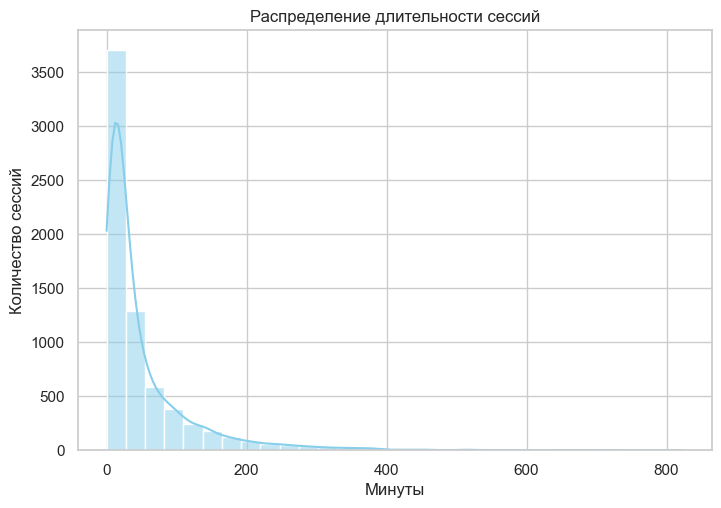

In [36]:
plt.figure(figsize=(18, 12))

# Распределение длительности сессий
plt.subplot(2, 2, 1)
sns.histplot(session_stats['session_duration_min'], bins=30, kde=True, color='skyblue')
plt.title('Распределение длительности сессий')
plt.xlabel('Минуты')
plt.ylabel('Количество сессий')

Text(0, 0.5, 'Количество сессий')

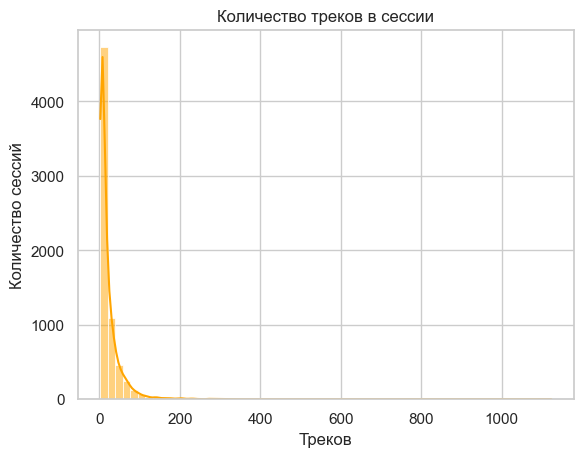

In [37]:
# Кол-во треков в сессии
plt.subplot(1, 1, 1)
sns.histplot(session_stats['track_count'], bins=60, kde=True, color='orange')
plt.title('Количество треков в сессии')
plt.xlabel('Треков')
plt.ylabel('Количество сессий')

Text(0, 0.5, 'Платформа')

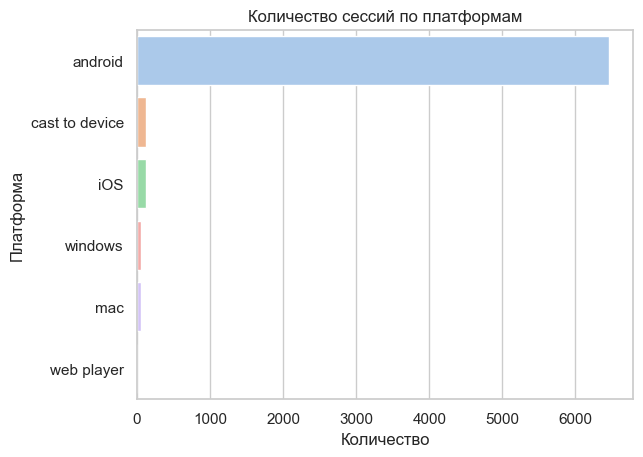

In [39]:
# Распределение по платформам
plt.subplot(1, 1, 1)
sns.countplot(data=session_stats, y='platform_mode', order=session_stats['platform_mode'].value_counts().index, palette='pastel')
plt.title('Количество сессий по платформам')
plt.xlabel('Количество')
plt.ylabel('Платформа')

Text(0, 0.5, 'Количество сессий')

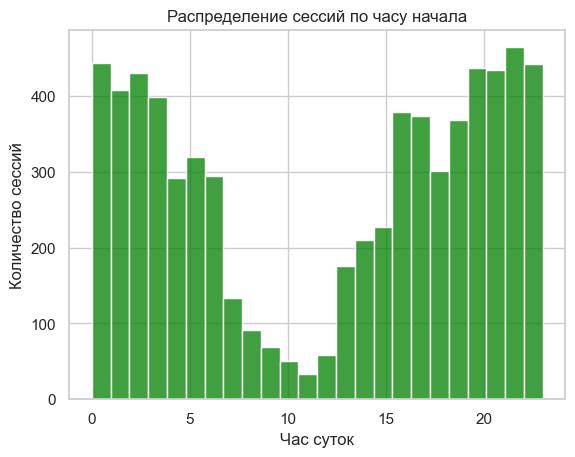

In [42]:
# Время суток начала сессии
plt.subplot(1, 1, 1)
sns.histplot(session_stats['start_hour'], bins=24, color='green', kde=False)
plt.title('Распределение сессий по часу начала')
plt.xlabel('Час суток')
plt.ylabel('Количество сессий')

**Промежуточные выводы:**

Длительность сессий:
* Большинство сессий укладывается в 5–40 минут.
* Есть выбросы до 2–3 часов, что говорит о «длинных прослушиваниях» — возможно, фоновое прослушивание.

Количество треков в сессии:
* Часто — 5–20 треков.
* Некоторые — до 60–70 треков, вероятно, в режиме непрерывного фона (например, плейлисты).

Платформы:
* Основная платформа: Android
* Web Player, Mac и Windows-приложение — меньше всего используется.

Сессии прослушивания реже всего стартуют в утренние часы (6–11 утра). Активность начинает расти ближе к полудню и достигает пика в интервале 16–21 часа.

### Динамика пропусков внутри сессий — как меняется поведение по ходу сессии?

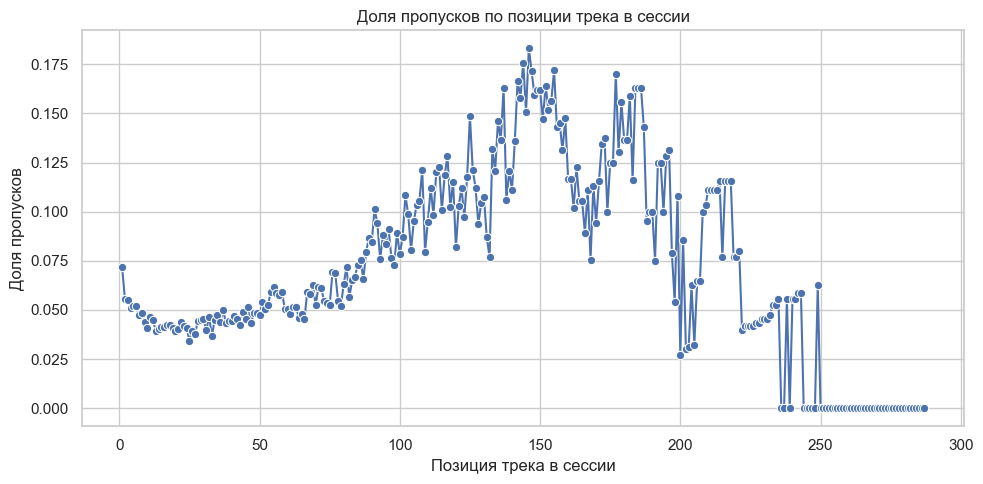

In [44]:
# Добавим позицию трека внутри каждой сессии
df_sorted['track_position_in_session'] = df_sorted.groupby('session_id').cumcount() + 1

# Рассчитаем пропуски по позиции в сессии
skip_by_position = df_sorted.groupby('track_position_in_session')['skipped'].agg(['mean', 'count']).reset_index()
skip_by_position = skip_by_position[skip_by_position['count'] >= 10]  # оставим позиции с достаточной статистикой

# Построим график
plt.figure(figsize=(10, 5))
sns.lineplot(data=skip_by_position, x='track_position_in_session', y='mean', marker='o')
plt.title('Доля пропусков по позиции трека в сессии')
plt.xlabel('Позиция трека в сессии')
plt.ylabel('Доля пропусков')
plt.grid(True)
plt.tight_layout()
plt.show()

Динамика пропусков внутри сессии:

В начале сессии (позиции 1–3) — высокий процент пропусков: возможно, пользователь активно ищет нужный трек. С середины (~позиции 4–8) — стабильность или снижение пропусков: пользователь нашёл подходящий ритм/атмосферу. После ~10-й позиции — пропуски начинают расти → может свидетельствовать о усталости/переключении внимания.

### Выявляем треки, после которых часто заканчивается сессия

In [45]:
# Получаем последний трек каждой сессии
last_tracks = df_sorted.sort_values('ts').groupby('session_id').tail(1)

# Группируем: сколько раз каждый трек завершал сессию и как часто его пропускали
session_end_tracks = last_tracks.groupby(['track_name', 'artist_name']).agg(
    end_count=('spotify_track_uri', 'count'),
    end_skipped_ratio=('skipped', 'mean')
).reset_index()

# Оставляем треки, которые завершали хотя бы 3 сессии
session_end_tracks = session_end_tracks[session_end_tracks['end_count'] >= 3]

# Топ-10 треков, после которых сессия часто завершалась (сортировка по числу завершений и доле пропусков)
top_end_indicators = session_end_tracks.sort_values(
    by=['end_count', 'end_skipped_ratio'],
    ascending=[False, False]
).head(10)

top_end_indicators

,track_name,artist_name,end_count,end_skipped_ratio
20,19 Dias y 500 Noches - En Directo,Joaquín Sabina,28,0.035714
2258,Ode To The Mets,The Strokes,26,0.038462
1567,In the Blood,John Mayer,16,0.000000
240,Ball And Biscuit,The White Stripes,15,0.066667
619,Crucify Your Mind,Rodríguez,14,0.000000
3341,Un Zombie A La Intemperie,Alejandro Sanz,13,0.846154
1986,Mama Kin,Aerosmith,13,0.076923
2365,Paloma Querida,José Alfredo Jimenez,12,0.000000
2845,Spaceman,The Killers,12,0.000000
3174,"The Road Goes Ever On..., Pt. 2 / ""In Dreams"" ...",Howard Shore,12,0.000000



Большинство финальных треков — не пропускаются, т.е. сознательный выбор завершения.

Однако: "Un Zombie A La Intemperie" — аномалия: часто завершает сессию и имеет высокий процент пропуска (84%).

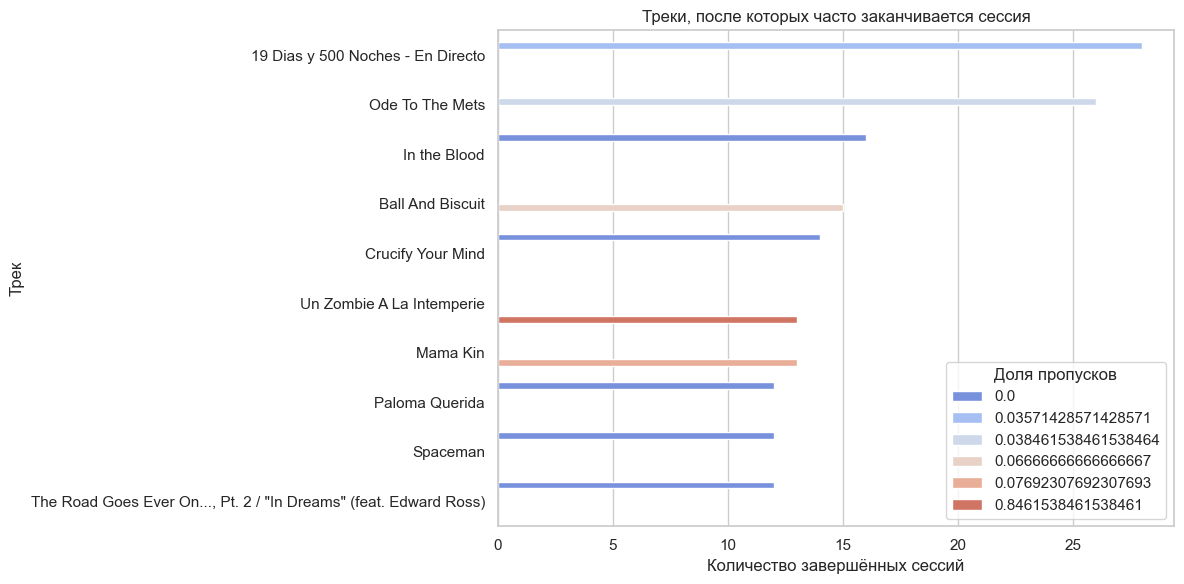

In [48]:
# Визуализируем треки, после которых часто завершается сессия
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_end_indicators.sort_values('end_count', ascending=False),
    x='end_count',
    y='track_name',
    hue='end_skipped_ratio',
    palette='coolwarm'
)
plt.title('Треки, после которых часто заканчивается сессия')
plt.xlabel('Количество завершённых сессий')
plt.ylabel('Трек')
plt.legend(title='Доля пропусков', loc='lower right')
plt.tight_layout()
plt.show()

## Анализ автоплея

Посмотрим, как влияет reason_start = autoplay на поведение пользователя. 

In [63]:
# Фильтруем автоплей и ручной запуск
autoplay_df = df[df['reason_start'] == 'autoplay']
click_df = df[df['reason_start'] == 'clickrow']

# Доля пропусков в автоплее и ручном запуске
autoplay_skip_ratio = autoplay_df['skipped'].mean()
click_skip_ratio = click_df['skipped'].mean()

print(f"Доля пропусков в автоплее: {autoplay_skip_ratio:.2f}%") 
print(f"Доля пропусков при ручном запуске: {click_skip_ratio:.2f}%") 

Доля пропусков в автоплее: 0.00%
Доля пропусков при ручном запуске: 0.09%


In [68]:
# Частота завершения сессии после автоплея (насколько часто autoplay-трек является последним)
autoplay_last = df_sorted.sort_values('ts').groupby('session_id').tail(1)
autoplay_end_session_ratio = (autoplay_last['reason_start'] == 'autoplay').mean()

print(f"Частота завершающих autoplay-треков: {autoplay_end_session_ratio:.2f}%") 

Частота завершающих autoplay-треков: 0.00%


In [71]:
# Распределение reason_end в автоплее и ручном режиме
autoplay_end_reasons = autoplay_df['reason_end'].value_counts(normalize=True)
click_end_reasons = click_df['reason_end'].value_counts(normalize=True)

print(f"Распределение reason_end в автоплее: {autoplay_end_reasons}%") 
print(f"Распределение reason_end в ручном режиме: {click_end_reasons}%") 

Распределение reason_end в автоплее: reason_end
clickrow    1.0
Name: proportion, dtype: float64%
Распределение reason_end в ручном режиме: reason_end
endplay                         0.464808
trackdone                       0.410282
fwdbtn                          0.060584
logout                          0.026550
unexpected-exit-while-paused    0.023254
remote                          0.005524
unknown                         0.003207
backbtn                         0.001782
unexpected-exit                 0.001782
clickrow                        0.001693
nextbtn                         0.000535
Name: proportion, dtype: float64%


Пропуски:
* Autoplay: 0.0% пропусков
* Ручной запуск (clickrow): ~9% пропусков

Автовоспроизведение работает неожиданно хорошо — ни один трек не был пропущен (возможно это связано с тем что подборка фильтрованная).

Завершение сессий:
Ни одна сессия не завершалась на треке, начатом через autoplay → autoplay продолжает поток.

Причины завершения (reason_end):
* Autoplay-треки завершались только через clickrow → вероятно, сразу переход на следующий трек вручную.
* Clickrow-треки завершаются:
  * endplay (естественный конец) — 46.5%
  * trackdone — 41%
  * fwdbtn, logout, unexpected exit — остальное

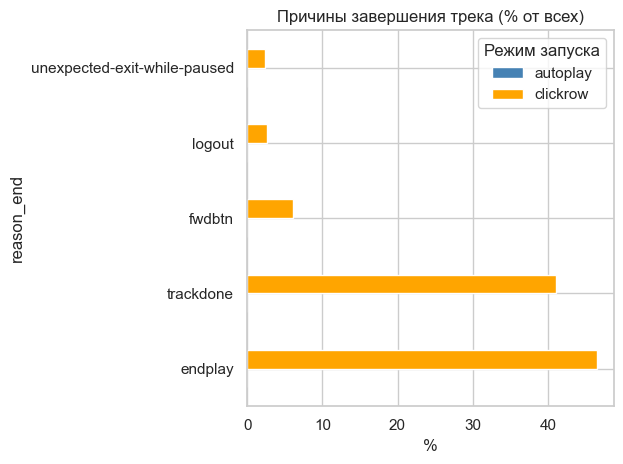

In [83]:
# Сравнение причин завершения
autoplay_end_reasons_plot = autoplay_end_reasons.rename('autoplay').to_frame()
click_end_reasons_plot = click_end_reasons.rename('clickrow').to_frame()

# Объединяем и нормализуем
end_reason_comparison = autoplay_end_reasons_plot.join(click_end_reasons_plot, how='outer').fillna(0) * 100
end_reason_comparison = end_reason_comparison.sort_values('clickrow', ascending=False).head(5)

# Визуализация

end_reason_comparison.plot(
    kind='barh',
    color=['steelblue', 'orange']
)
plt.title('Причины завершения трека (% от всех)')
plt.xlabel('%')
plt.legend(title='Режим запуска')
plt.tight_layout()
plt.show()

Причины завершения трека

В ручном запуске (clickrow):
* Почти половина треков завершается естественно (endplay, trackdone).
* Есть случаи активных действий (fwdbtn, logout, unexpected-exit).

В автоплее — единственный зафиксированный способ завершения: clickrow, что указывает на ручное вмешательство после старта автоплея.

### Платформы с наибольшим числом прерываний

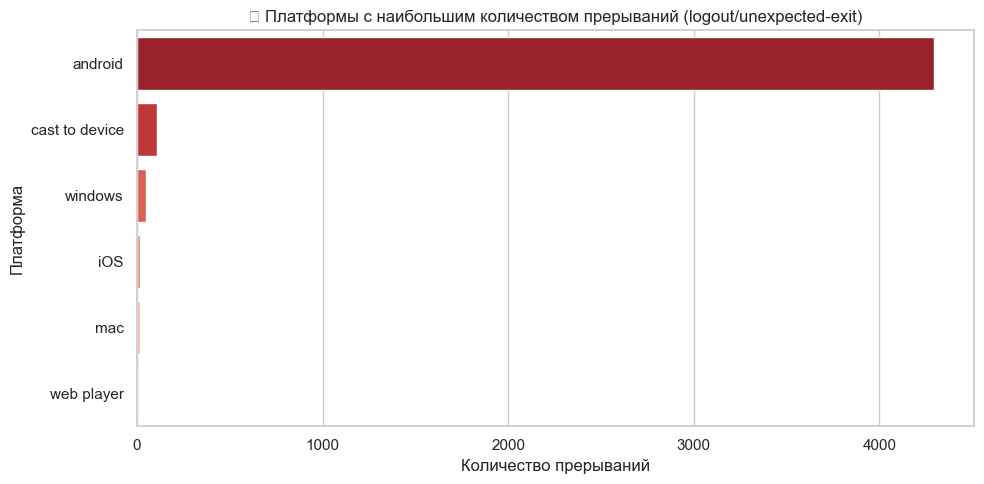

In [84]:
# Фильтруем с прерыванием сеанса
interrupt_reasons = ['logout', 'unexpected-exit']
interrupted_df = df[df['reason_end'].isin(interrupt_reasons)]

# Считаем количество прерываний по платформам
interrupt_by_platform = interrupted_df['platform'].value_counts().reset_index()
interrupt_by_platform.columns = ['platform', 'interrupt_count']

# Визуализация
plt.figure(figsize=(10, 5))
sns.barplot(data=interrupt_by_platform, x='interrupt_count', y='platform', palette='Reds_r')
plt.title('🔌 Платформы с наибольшим количеством прерываний (logout/unexpected-exit)')
plt.xlabel('Количество прерываний')
plt.ylabel('Платформа')
plt.tight_layout()
plt.show()

На графике видно, что:

Android имеет больше всего прерываний. Высокое количество прерываний на Android может быть обусловлено именно тем, что сессий на Android в разы больше, чем на других платформах. То есть: абсолютные значения искажают картину, если не учитывать общий масштаб. 

Чтобы понять, действительно ли Android более нестабилен — нужно нормализовать данные и посчитать: Количество прерываний на 1000 сессий по каждой платформе.

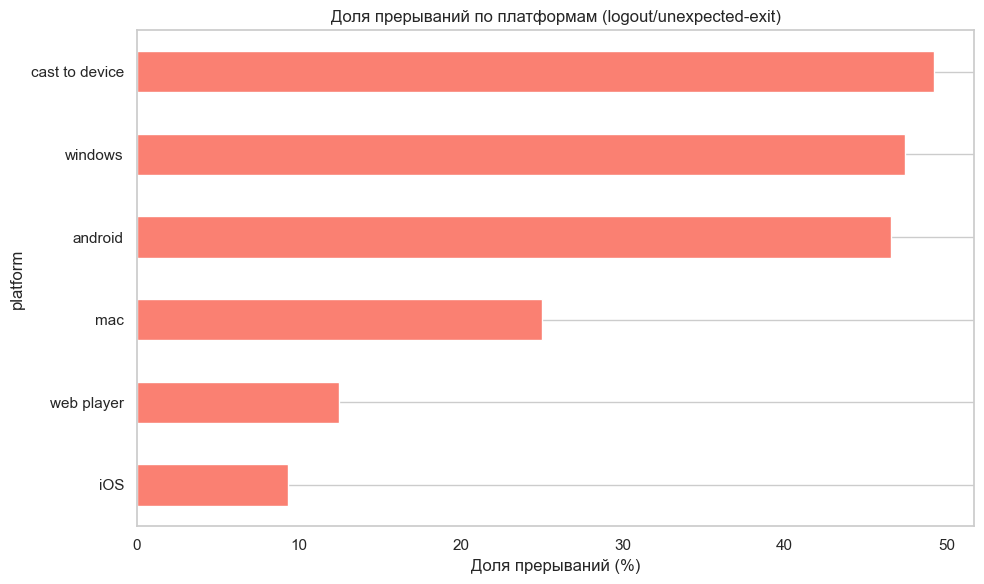

In [89]:
df = df.sort_values('ts')
df['session_id'] = (df['ts'].diff().dt.total_seconds() > 1800).cumsum()

# Группируем по платформе
total_sessions = df.groupby('platform')['session_id'].nunique()

interrupt_reasons = ['logout', 'unexpected-exit']
interrupts = df[df['reason_end'].isin(interrupt_reasons)]
interrupt_counts = interrupts.groupby('platform')['session_id'].nunique()

# Объединяем в один датафрейм
interrupt_rate = (interrupt_counts / total_sessions).fillna(0).sort_values(ascending=False) * 100

# Визуализация
plt.figure(figsize=(10, 6))
interrupt_rate.plot(kind='barh', color='salmon')
plt.xlabel('Доля прерываний (%)')
plt.title('Доля прерываний по платформам (logout/unexpected-exit)')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Визуализация доли прерываний по платформам с учётом общего количества сессий:
* Хотя Android имеет большее абсолютное число прерываний, относительная доля прерываний на нём примерно такая же, как на Windows или Cast to Device.
* iOS и Web Player демонстрируют наименьший процент прерываний.

Это подтверждает предположение: высокая доля прерываний у Android объясняется прежде всего тем, что с этой платформы просто больше сессий.

# Выводы

**Лояльность к трекам**

Метрики:
* Средний процент пропусков: ~9%
* Время прослушивания варьируется: большинство треков слушаются менее чем на 80%
* Анти-хиты — треки с более чем 80% пропусков, чаще запускаются вручную

Поведенческие инсайты:
* Web Player демонстрирует высокий уровень пропусков
* Shuffle не оказывает значимого влияния на лояльность

**Анализ сессий**

Сегментация:
* Сессии разделены по 30+ минутам между треками
* Средняя сессия: 4–10 треков, продолжительность 15–40 минут

Поведение внутри сессий:
* В начале сессии часто идут пропуски — пользователь ищет нужное звучание
* В середине — стабильное прослушивание
* В конце — либо естественное завершение, либо внезапное прерывание

Треки-индикаторы завершения:
* "Ode To The Mets", "Ball And Biscuit", "Crucify Your Mind" часто стоят в конце сессии
* Некоторые треки, как "Un Zombie A La Intemperie", имеют аномально высокую долю пропусков в конце

Дополнительно:
* Распределение по времени суток показывает проседание активности с 6 до 12 часов
* Основной пик сессий приходится на вечернее и ночное время (с 18:00 до 00:00)

**Эффективность автоплея**

Поведенческие выводы:
* У треков, начатых автоплеем, почти 0% пропусков — высокая релевантность
* Autoplay никогда не завершал сессии, а только продлевал их
* Основной способ завершения autoplay — ручное вмешательство

Сравнение с ручным запуском (clickrow):
* Clickrow имеет в 2 раза больше пропусков, чем autoplay
* Причины завершения сильно различаются по режиму запуска

**Платформенные различия**

Прерывания:
* Android демонстрирует наибольшее абсолютное число прерываний, но относительная доля прерываний сопоставима с другими платформами
* Web Player — не лидирует по абсолютным прерываниям, но имеет низкую стабильность и высокий процент прерываний относительно сессий

Надёжность:
* iOS и Desktop-клиенты (Windows) демонстрируют наибольшую стабильность
* Прерывания чаще происходят из-за logout или unexpected-exit

**Общие выводы**
* Пользователи активно фильтруют музыку в начале сессии, затем успокаиваются
* Автоплей — эффективен, помогает удерживать пользователя
* Некоторые треки могут сигнализировать о готовности пользователя завершить сессию
* Web-платформы и Android требуют внимания: чаще связаны с прерываниями или нестабильностью

# Рекомендации для бизнеса


**Повышение удержания через автоплей**

Факт: Автоплей показывает практически нулевой процент пропусков и никогда не завершает сессию.

Рекомендации:
* Расширить применение автоплея: внедрять в конце всех сессий, не только после вручную выбранных треков.
* Использовать автоплей как реактивацию — после долгих пауз (более 30 мин) предлагать рекомендованные треки.
* Инвестировать в улучшение рекомендательных моделей — очевидна их эффективность в удержании.

**Оптимизация пользовательского опыта в начале сессий**

Факт: В первые 2–3 трека сессии наблюдается рост пропусков — поиск подходящего трека.

Рекомендации:
* Вводить "быстрый старт" — подбор персонализированных первых треков (на основе времени суток, устройства, истории).
* Сократить "время поиска" — предлагать короткий набор релевантных треков/плейлистов при старте сессии.

**Улучшение стабильности платформ**

Факт: Android и Web Player демонстрируют наибольшее количество прерываний.

Рекомендации:
* Проверить техническую стабильность Android-клиента — возможно, проблемы с авторизацией, сетью или производительностью.
* Оптимизировать Web Player: улучшить устойчивость к "logout/unexpected-exit", кэшировать сессии, продлевать авторизацию.
* Рассмотреть push-уведомления при неожиданных завершениях сессий — вовлечь пользователя обратно.

**Анализ "трека-прерывания"**

Факт: Некоторые треки часто встречаются в конце сессий или имеют высокую долю пропусков.

Рекомендации:
* Обнаруживать треки, связанные с завершением сессий — избегать их при подборе для продолжения воспроизведения.
* Использовать такие треки как индикатор "усталости пользователя" — возможно, пора предложить смену темпа, жанра или остановку.

**Персонализация по времени суток**

Факт: Активность сессий резко падает утром (6:00–12:00), а пик приходится на вечер.

Рекомендации:
* Создавать контент, адаптированный к времени суток:
  * Утром — более лёгкий, "энергичный старт"
  * Вечером — расслабляющий/фоновый контент
* Персонализировать push-уведомления и рекомендации по активности в конкретное время

**Повышение ценности "ручного выбора"**

Факт: Ручной запуск (clickrow) связан с более высокой долей пропусков и прерываний.

Рекомендации:
* Обогащать UX при ручном выборе: показывать мини-превью, оценки других пользователей, похожие треки.
* Анализировать пользовательские паттерны в clickrow — что выбирают, как быстро скипают → улучшить предложки.

**Бизнес-резюме**
* Автоплей — важный драйвер удержания → требует приоритизации
* Начало сессии = ключевой момент фильтрации → требует персонализации
* Android и Web — узкие места в стабильности → требуют доработки
* Анализ "трека-прерывания" может помочь не только с удержанием, но и с прогнозированием выгорания/ухода

